In [1]:
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import ncvis
import numpy as np
import os
from plotting import plot_prior, plot_vardistr, plot_digit_samples, get_samples
from data import Dataset
%matplotlib inline

import pdb

device = "cuda:1" if torch.cuda.is_available() else "cpu" 

In [2]:
####################################
general_name = 'data_mnist_skips_False_prior_None_numflows_1_varflow_None_numvarflows_1_samples_1_zdim_64'
####################################

In [3]:
dataset = general_name.split('_')[1]

### Prior plotting

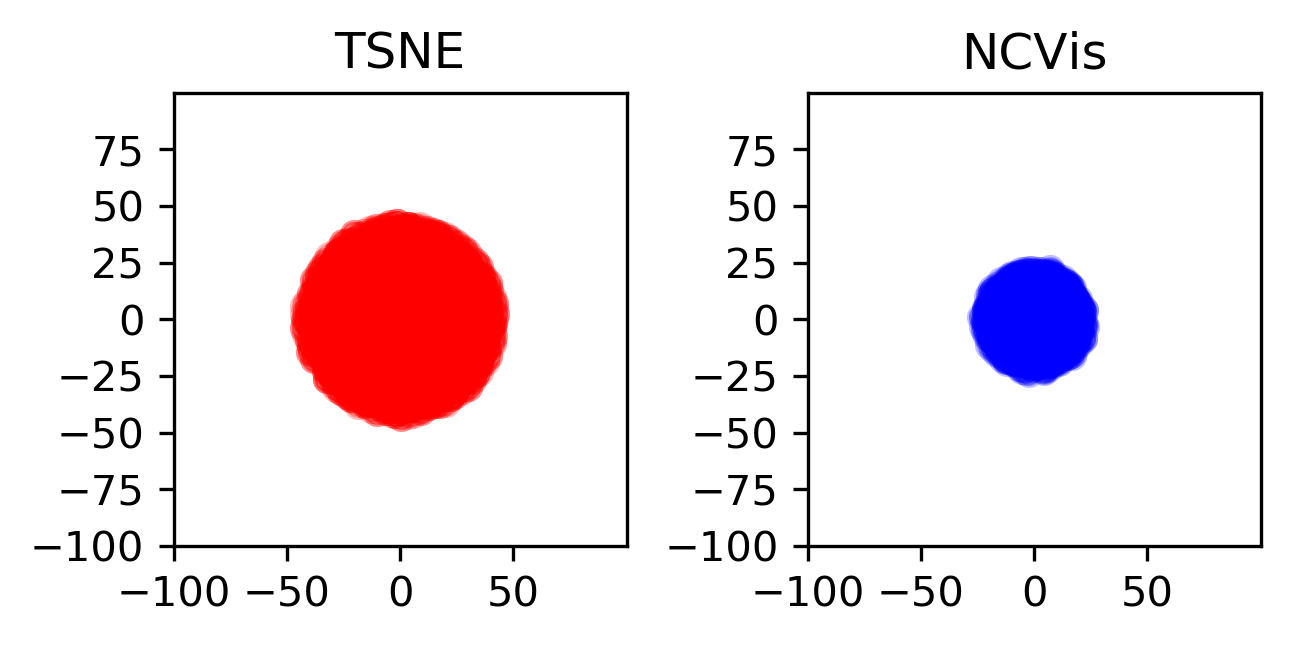

In [4]:
filename = 'prior_{}'.format(general_name + '.txt')
full_name = os.path.join('./plot_data/{}'.format(dataset), filename)
if os.path.exists(full_name):
    file = open(full_name)
    data = np.array([float(val) for val in ' '.join([value for value in file.read().split('\n')][:-1]).split(' ')]).reshape(-1, 64)
    fig, ax = plt.subplots(ncols=2, figsize=(5, 2), dpi=300, sharex=True)
    limx, limy = 100, 100
    #### TSNE ####
    tsne = TSNE(n_components=2)
    compressed_data = tsne.fit_transform(data)
    ax[0].set_title('TSNE')
    ax[0].scatter(compressed_data[:, 0], compressed_data[:, 1], c='r', alpha=0.25)
    ax[0].set_xlim((-limx, limx))
    ax[0].set_ylim((-limy, limy))
    ax[0].set_xticks(np.arange(-limx, limx, 50))
    ax[0].set_yticks(np.arange(-limy, limy, 25))
    ax[0].set_aspect('equal', 'box')

    ### NCVIS ###
    vis = ncvis.NCVis()
    compressed_data = vis.fit_transform(data)
    ax[1].set_title('NCVis')
    ax[1].scatter(compressed_data[:, 0], compressed_data[:, 1], c='b', alpha=0.25)
    ax[1].set_xlim((-limx, limx))
    ax[1].set_ylim((-limy, limy))
    ax[1].set_xticks(np.arange(-limx, limx, 50))
    ax[1].set_yticks(np.arange(-limy, limy, 25))
    ax[1].set_aspect('equal', 'box')
    
else:
    print('NO data found!')

### Samples plotting

In [5]:
filename = 'best_decoder_{}'.format(general_name + '.pt')
full_name = os.path.join('./models/{}'.format(dataset), filename)
if os.path.exists(full_name):
    decoder = torch.load(full_name, map_location=device)
else:
    decoder = None

In [6]:
filename = 'best_encoder_{}'.format(general_name + '.pt')
full_name = os.path.join('./models/{}'.format(dataset), filename)
if os.path.exists(full_name):
    encoder = torch.load(full_name, map_location=device)
else:
    encoder = None

In [7]:
filename = 'best_prior_{}'.format(general_name + '.pt')
full_name = os.path.join('./models/{}'.format(dataset), filename)
if os.path.exists(full_name):
    prior = torch.load(full_name, map_location=device)
else:
    prior = None

In [8]:
decoder

Decoder(
  (linear1): Linear(in_features=64, out_features=450, bias=True)
  (linear2): Linear(in_features=450, out_features=512, bias=True)
  (deconv1): ConvTranspose2d(32, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (deconv2): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
  (deconv3): ConvTranspose2d(16, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
)

In [9]:
encoder

Encoder(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (linear): Linear(in_features=512, out_features=450, bias=True)
  (mu): Linear(in_features=450, out_features=64, bias=True)
  (sigma): Linear(in_features=450, out_features=64, bias=True)
)

In [10]:
prior

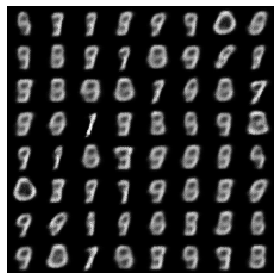

In [11]:
random_code = torch.distributions.Normal(loc=torch.tensor(0., device=device),
                                                scale=torch.tensor(1., device=device)).sample((64, 64))
if prior:
    for i in range(len(prior)):
        random_code = prior[i]._inverse(random_code)
plot_digit_samples(get_samples(gen_network=decoder, random_code=random_code))

### Posterior plotting

In [ ]:
filename_labels = 'vardistr_labels_{}'.format(general_name + '.txt')
filename_points = 'vardistr_points_{}'.format(general_name + '.txt')
full_name_labels = os.path.join('./plot_data/{}'.format(dataset), filename_labels)
full_name_points = os.path.join('./plot_data/{}'.format(dataset), filename_points)

data_exist = True
if os.path.exists(full_name_labels):
    file_labels = open(full_name_labels)
else:
    data_exist = False
if os.path.exists(full_name_points):
    file_points = open(full_name_points)
else:
    data_exist = False

if data_exist:
    plt.close()
    strl = file_labels.read()
    labels_np = np.array([float(val) for val in strl.split('\n')[:-1]])

    strp = file_points.read()
    points_np = np.array([float(val) for val in ' '.join(strp.split('\n')).split(' ')[:-1]]).reshape(labels_np.shape[0], -1)
    
    fig, ax = plt.subplots(ncols=2, figsize=(10, 4), dpi=300)
    limx, limy = 90, 90
    #### TSNE ####
    tsne = TSNE(n_components=2)
    compressed_data = tsne.fit_transform(points_np)
    ax[0].set_title('TSNE')
    for label in np.unique(labels_np):
        ind = np.argwhere(labels_np==label).squeeze()
        zero = np.zeros_like(ind)
        ax[0].scatter(compressed_data[ind, zero], compressed_data[ind, zero + 1], alpha=0.25, label=label)
    ax[0].set_xlim((-limx, limx))
    ax[0].set_ylim((-limy, limy))
    ax[0].set_xticks(np.arange(-limx, limx, 25))
    ax[0].set_yticks(np.arange(-limy, limy, 25))
    ax[0].legend()
    ax[0].set_aspect('equal', 'box')

    limx, limy = 35, 35
    ### NCVIS ###
    vis = ncvis.NCVis()
    compressed_data = vis.fit_transform(points_np)
    ax[1].set_title('NCVis')
    for label in np.unique(labels_np):
        ind = np.argwhere(labels_np==label).squeeze()
        zero = np.zeros_like(ind)
        ax[1].scatter(compressed_data[ind, zero], compressed_data[ind, zero + 1],  alpha=0.25, label=label)
    ax[1].set_xlim((-limx, limx))
    ax[1].set_ylim((-limy, limy))
    ax[1].set_xticks(np.arange(-limx, limx, 25))
    ax[1].set_yticks(np.arange(-limy, limy, 25))
    ax[1].legend()
    ax[1].set_aspect('equal', 'box')
else:
    print('NO data found')